In [13]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd())) 
from src.load_dataset import load_dataset
from src.train_cnn import build_model
from src.predict_emotion import predict_emotion
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

In [3]:
train_data, val_data = load_dataset()
print("Dataset classes:", train_data.dataset.classes)

Path to dataset files: /Users/myeoh/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1
Train batches: 28821
Validation batches: 7066
Dataset classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# ----------------------------------------------------------------------
# Code adapted from PyTorch CIFAR-10 tutorial: 
# https://pytorch.org/tutorials/downloads/cifar10_tutorial.py
# ----------------------------------------------------------------------
net = build_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# Early stopping
best_val_acc = 0
patience_counter = 0
patience = 20

# helper function
def calculate_accuracy(data_loader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

train_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    epoch_loss = running_loss / len(train_data)
    train_loss.append(epoch_loss)
    
    train_acc = calculate_accuracy(train_data, net)
    train_accuracy.append(train_acc)
    print(f'Accuracy on training set: {train_acc:.2f} %')

    test_acc = calculate_accuracy(val_data, net)
    test_accuracy.append(test_acc)
    print(f'Accuracy on test set: {test_acc:.2f} %')
    
    # Learning rate scheduling and early stopping
    scheduler.step(epoch_loss)
    
    if test_acc > best_val_acc:
        best_val_acc = test_acc
        patience_counter = 0
        # Save best model
        project_root = os.path.dirname(os.getcwd())
        os.makedirs(os.path.join(project_root, "models"), exist_ok=True)
        save_path = os.path.join(project_root, "models", "emotion_net_best.pth")
        torch.save(net.state_dict(), save_path)
        print(f"Saved best model to {save_path}")
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break


print('Finished Training')

# Save model
project_root = os.path.dirname(os.getcwd())
os.makedirs(os.path.join(project_root, "models"), exist_ok=True)
save_path = os.path.join(project_root, "models", "emotion_net.pth")
torch.save(net.state_dict(), save_path)
print(f"Saved model to {save_path}")

Accuracy on training set: 29.55 %
Accuracy on test set: 32.52 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 36.86 %
Accuracy on test set: 38.98 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 38.95 %
Accuracy on test set: 42.58 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 41.13 %
Accuracy on test set: 43.87 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 42.77 %
Accuracy on test set: 45.02 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 42.00 %
Accuracy on test set: 44.49 %
Accuracy on training set: 43.16 %
Accuracy on test set: 46.18 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 44.84 %
Accuracy on test set: 47.57 %
Sa

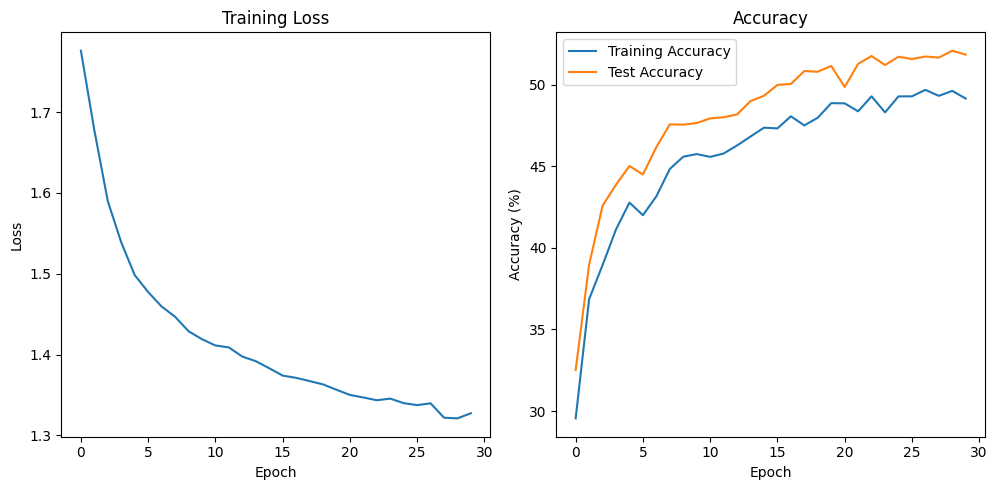

In [5]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

fear.jpg: sad (0.207)
disgust.jpg: sad (0.403)
surprise.jpg: surprise (0.723)
happy.jpg: happy (0.521)
sad.jpg: sad (0.346)


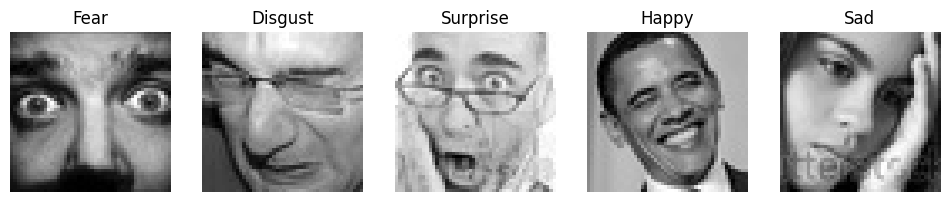

In [12]:
#test images

fig, axes = plt.subplots(1, 5, figsize=(12, 6))

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

for i, img_name in enumerate(['fear.jpg', 'disgust.jpg', 'surprise.jpg', 'happy.jpg', 'sad.jpg']):
    image = Image.open(img_name).convert('L')
    image_tensor = transform(image).squeeze(0)
    
    axes[i].imshow(image_tensor, cmap='gray')
    axes[i].set_title(img_name.split('.')[0].capitalize())
    axes[i].axis('off')
    
    result = predict_emotion(image_tensor, model_path='../models/emotion_net.pth')
    print(f"{img_name}: {result['emotion']} ({result['confidence']:.3f})")

plt.show()
